# California Housing Prices - Residential Real Estate

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import shap
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [187]:
df = pd.read_csv("/kaggle/input/california-housing-prices/housing.csv")

print("Dataset shape:", df.shape)
print("\nData overview:")
display(df.head())
print("\nData information:")
display(df.info())
print("\nMissing values:")
display(df.isnull().sum())

df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)

print("\nOcean proximity distribution:")
display(df['ocean_proximity'].value_counts())

df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

# Encode categorical features - both numerical for clustering and one-hot for regression
mapping = {'<1H OCEAN': 1, 'INLAND': 2, 'NEAR OCEAN': 3, 'NEAR BAY': 4, 'ISLAND': 5}
df['ocean_proximity_encoded'] = df['ocean_proximity'].map(mapping)

Dataset shape: (20640, 10)

Data overview:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY



Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None


Missing values:


,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0



Ocean proximity distribution:


<ipython-input-187-3ed9b28b1c8b>:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


# Exploratory Data Analysis


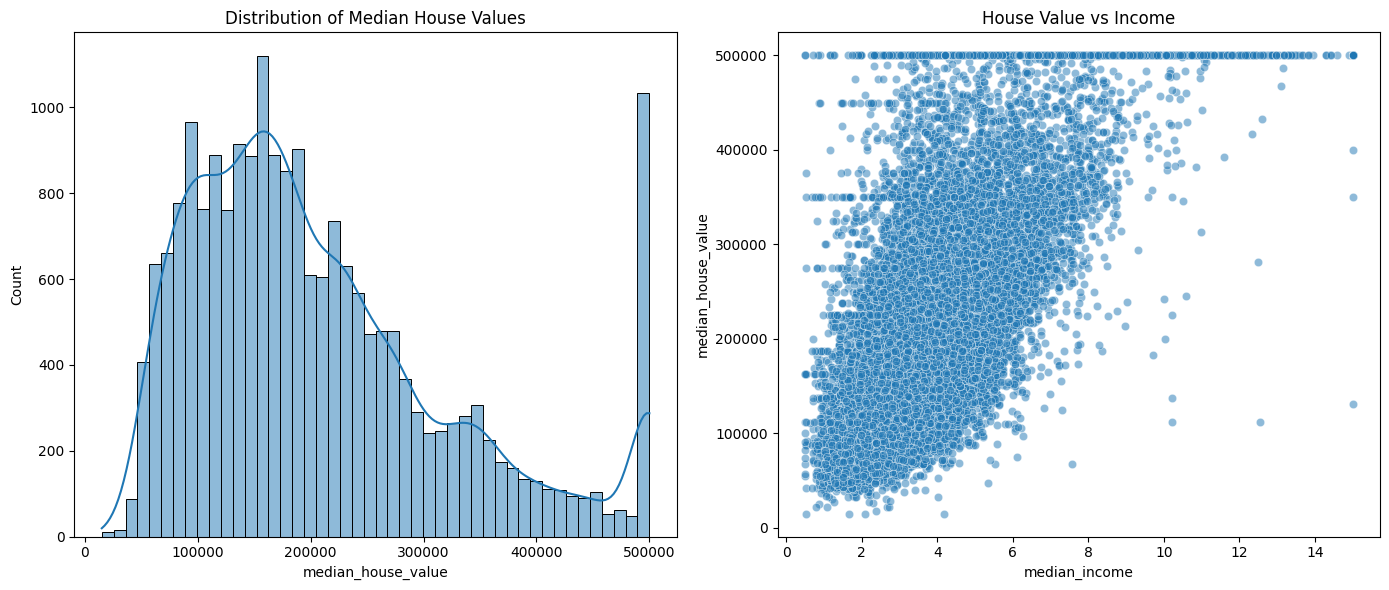

In [189]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['median_house_value'], kde=True)
plt.title('Distribution of Median House Values')

plt.subplot(1, 2, 2)
sns.scatterplot(x='median_income', y='median_house_value', data=df, alpha=0.5)
plt.title('House Value vs Income')

plt.tight_layout()
plt.show()

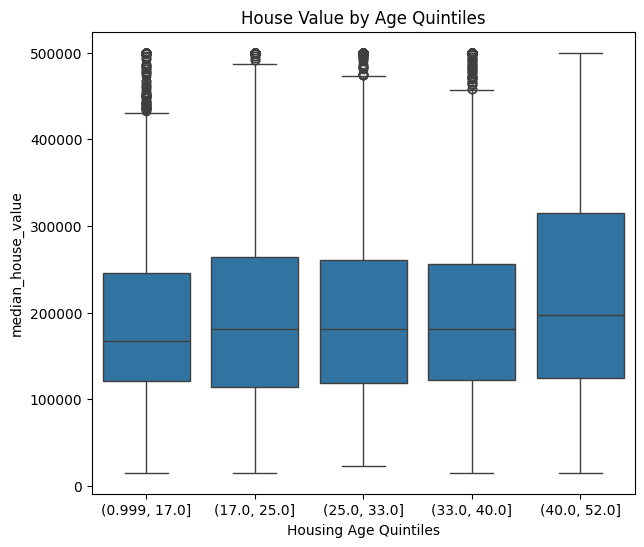

In [190]:
plt.figure(figsize=(7, 6))
sns.boxplot(x=pd.qcut(df['housing_median_age'], 5), y='median_house_value', data=df)
plt.title('House Value by Age Quintiles')
plt.xlabel('Housing Age Quintiles')

plt.show()

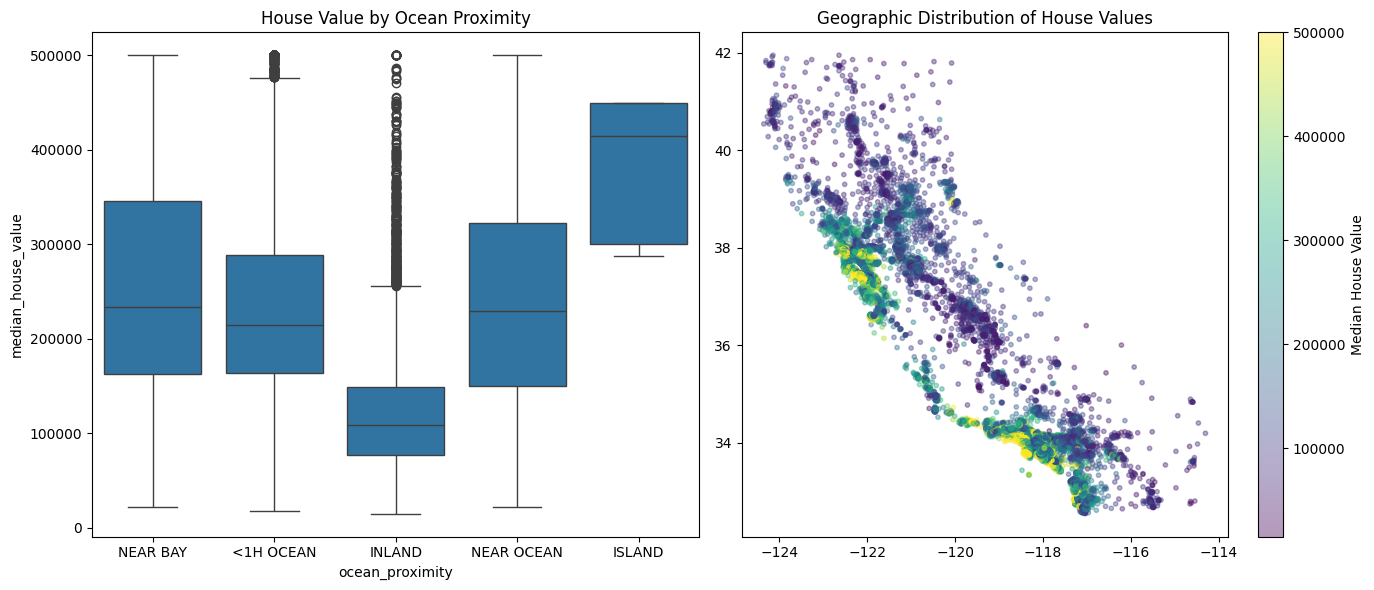

In [191]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='ocean_proximity', y='median_house_value', data=df)
plt.title('House Value by Ocean Proximity')

plt.subplot(1, 2, 2)
plt.scatter(df['longitude'], df['latitude'], alpha=0.4,
            c=df['median_house_value'], cmap='viridis', s=10)
plt.title('Geographic Distribution of House Values')
plt.colorbar(label='Median House Value')

plt.tight_layout()
plt.show()

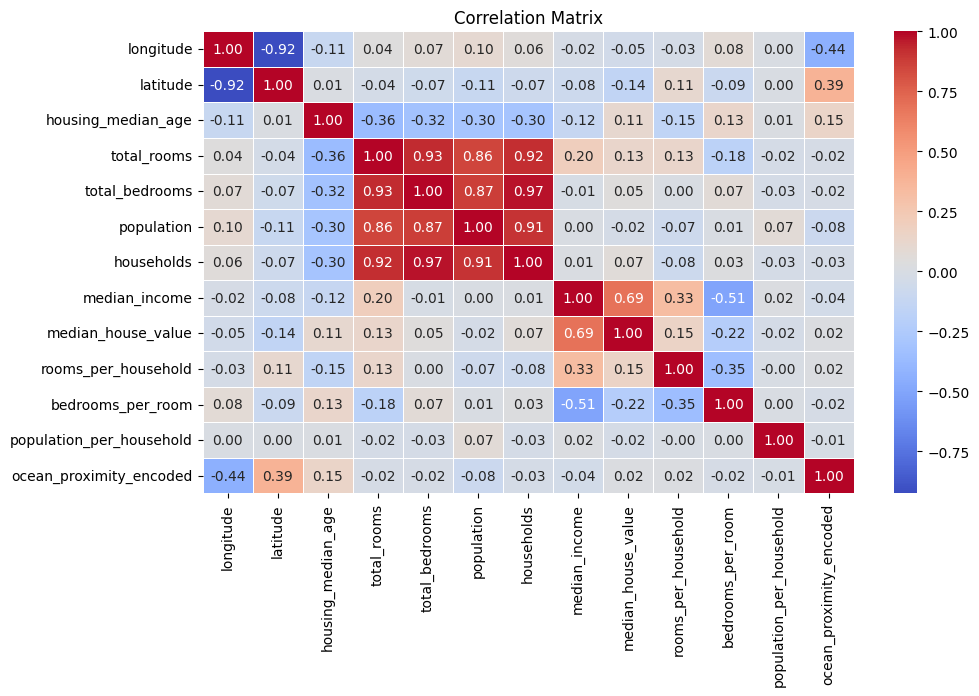

In [192]:
plt.figure(figsize=(10.5, 6))
corr_matrix = df.drop('ocean_proximity', axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')

plt.show()

# PART A: Supervised Learning for Price Prediction


In [193]:
X = df.drop(['median_house_value', 'ocean_proximity', 'ocean_proximity_encoded'], axis=1)
y = df['median_house_value']

numeric_features = X.columns.tolist()
categorical_features = ['ocean_proximity']

X_train, X_test, y_train, y_test = train_test_split(
    df[numeric_features + categorical_features],
    y,
    test_size=0.25,
    random_state=42
)

In [194]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [195]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting': GradientBoostingRegressor()
}

results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[name] = {'R²': r2, 'RMSE': rmse}

    print(f"\n{name} Results:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")


Linear Regression Results:
R² Score: 0.5965
RMSE: 73068.21

Ridge Regression Results:
R² Score: 0.5964
RMSE: 73076.62


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.744e+12, tolerance: 2.066e+10




Lasso Regression Results:
R² Score: 0.5965
RMSE: 73068.41

Gradient Boosting Results:
R² Score: 0.7873
RMSE: 53053.73


In [197]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
display(results_df)


Model Comparison:


,R²,RMSE
Linear Regression,0.596517,73068.208989
Ridge Regression,0.596424,73076.622855
Lasso Regression,0.596515,73068.407154
Gradient Boosting,0.787284,53053.732223


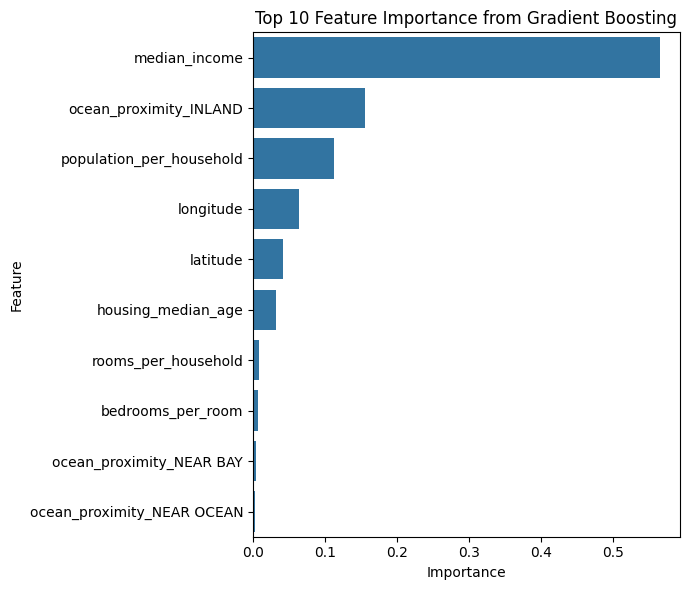

In [198]:
feature_names = (numeric_features +
                 list(gb_pipeline.named_steps['preprocessor']
                      .transformers_[1][1]
                      .named_steps['onehot']
                      .get_feature_names_out(categorical_features)))

feature_importance = gb_pipeline.named_steps['model'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(7, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importance from Gradient Boosting')
plt.tight_layout()
plt.show()

# PART B: Unsupervised Learning for Market Segmentation


In [200]:
cluster_features = [
    'median_income',
    'median_house_value',
    'households',
    'latitude',
    'longitude',
    'ocean_proximity_encoded'
]

X_cluster = df[cluster_features].copy()

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

    if k > 1:
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(X_cluster_scaled, labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)

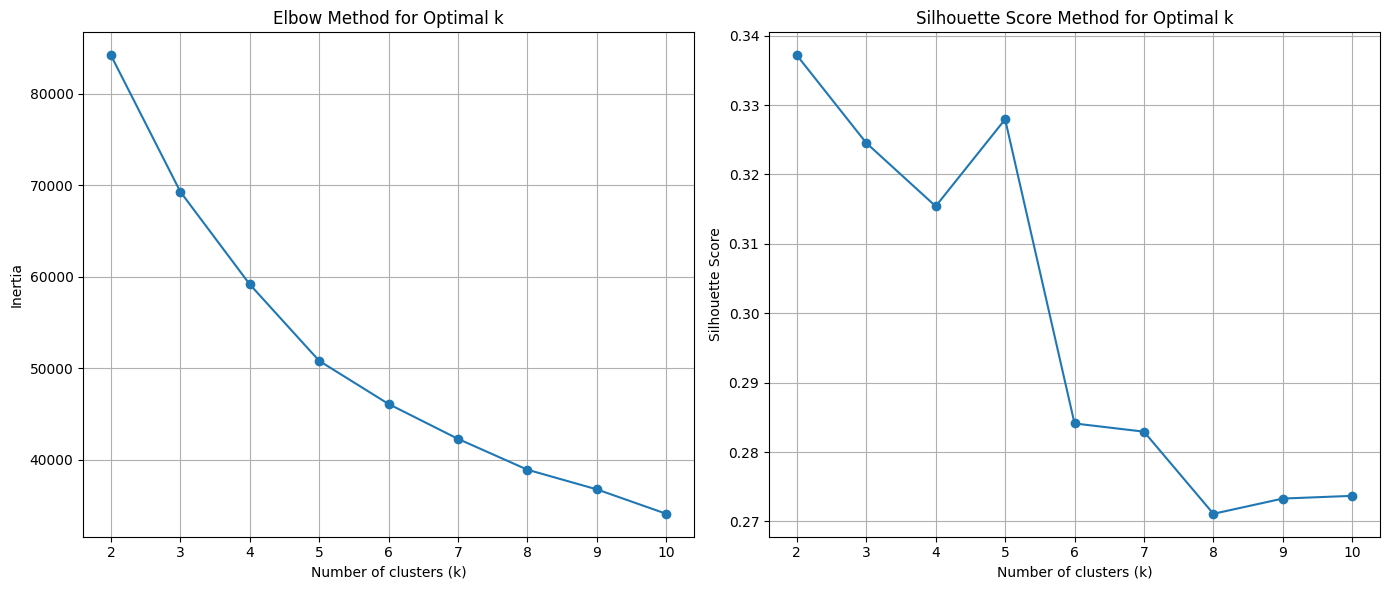

In [201]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Optimal k')
plt.grid(True)

plt.tight_layout()
plt.show()


In [209]:
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_cluster_scaled)

cluster_analysis = df.groupby('cluster').agg({
    'median_house_value': 'mean',
    'median_income': 'mean',
    'households': 'mean',
    'population': 'mean',
    'latitude': 'mean',
    'longitude': 'mean',
    'ocean_proximity': lambda x: x.mode()[0]
}).reset_index()

print("\nCluster Analysis:")
display(cluster_analysis)


Cluster Analysis:


,cluster,median_house_value,median_income,households,population,latitude,longitude,ocean_proximity
0,0,136177.959459,3.215239,420.370575,1198.167301,38.122777,-121.349572,INLAND
1,1,198618.134479,3.507987,449.997472,1390.887765,33.933895,-118.149607,<1H OCEAN
2,2,218821.775213,3.979255,1796.499392,4878.578372,34.883414,-118.832746,<1H OCEAN
3,3,408317.391380,7.217754,435.088376,1182.262952,34.573796,-118.903679,<1H OCEAN
4,4,139135.577477,3.032769,465.365187,1365.970303,33.886254,-117.637877,INLAND
5,5,267563.829410,4.098546,467.745821,1193.022177,37.669263,-122.224756,NEAR BAY


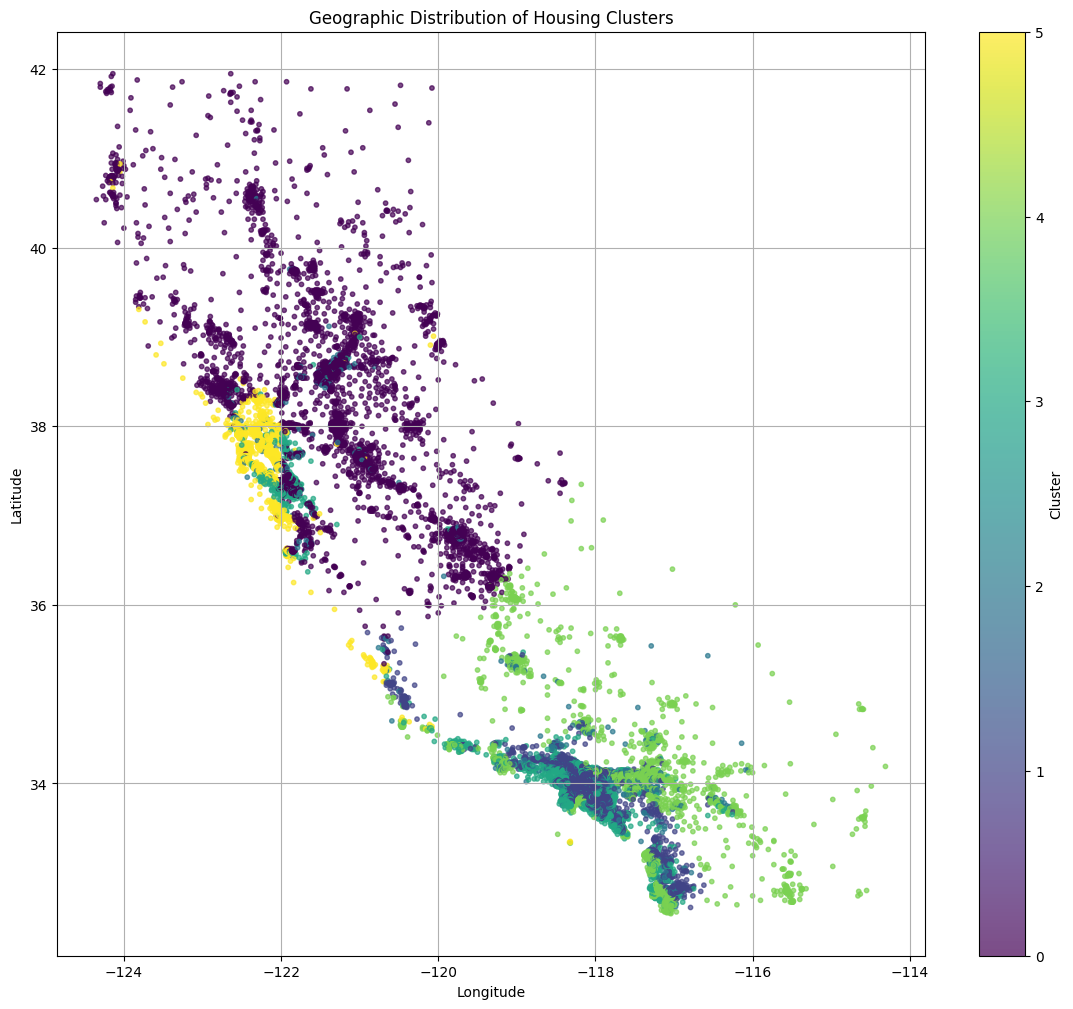

In [210]:
plt.figure(figsize=(14, 12))
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'],
            cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('Geographic Distribution of Housing Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [211]:
# Define California geographic regions based on cluster characteristics
def assign_region_name(row):
    if row['latitude'] > 36.8 and row['latitude'] < 38.8 and row['longitude'] > -123.5 and row['longitude'] < -121.5:
        return "San Francisco Bay Area"
    elif row['latitude'] > 33.3 and row['latitude'] < 34.9 and row['longitude'] > -119.4 and row['longitude'] < -117.6:
        return "Los Angeles Metro"
    elif row['latitude'] < 33.5 and row['longitude'] > -118:
        return "San Diego Region"
    elif row['latitude'] > 34.5 and row['latitude'] < 37 and row['longitude'] > -122 and row['longitude'] < -119.4:
        return "Central Coast"
    elif row['latitude'] > 38.8 and row['longitude'] > -124 and row['longitude'] < -119.5:
        return "Northern California"
    elif row['latitude'] < 35 and row['longitude'] > -119 and row['longitude'] < -115:
        return "Inland Empire"
    elif row['latitude'] > 34.8 and row['latitude'] < 40.3 and row['longitude'] > -123.1 and row['longitude'] < -119:
        return "Central Valley"
    else:
        return "San Joaquin Valley/Desert"

In [216]:
cluster_analysis['region_name'] = cluster_analysis.apply(assign_region_name, axis=1)
cluster_to_region = dict(zip(cluster_analysis['cluster'], cluster_analysis['region_name']))
df['region'] = df['cluster'].map(cluster_to_region)

print("\nCluster Analysis with Region Names:")
display(cluster_analysis[['cluster', 'region_name', 'median_house_value', 'median_income', 'latitude', 'longitude', 'ocean_proximity']])


Cluster Analysis with Region Names:


,cluster,region_name,median_house_value,median_income,latitude,longitude,ocean_proximity
0,0,Central Valley,136177.959459,3.215239,38.122777,-121.349572,INLAND
1,1,Los Angeles Metro,198618.134479,3.507987,33.933895,-118.149607,<1H OCEAN
2,2,Los Angeles Metro,218821.775213,3.979255,34.883414,-118.832746,<1H OCEAN
3,3,Los Angeles Metro,408317.391380,7.217754,34.573796,-118.903679,<1H OCEAN
4,4,Los Angeles Metro,139135.577477,3.032769,33.886254,-117.637877,INLAND
5,5,San Francisco Bay Area,267563.829410,4.098546,37.669263,-122.224756,NEAR BAY


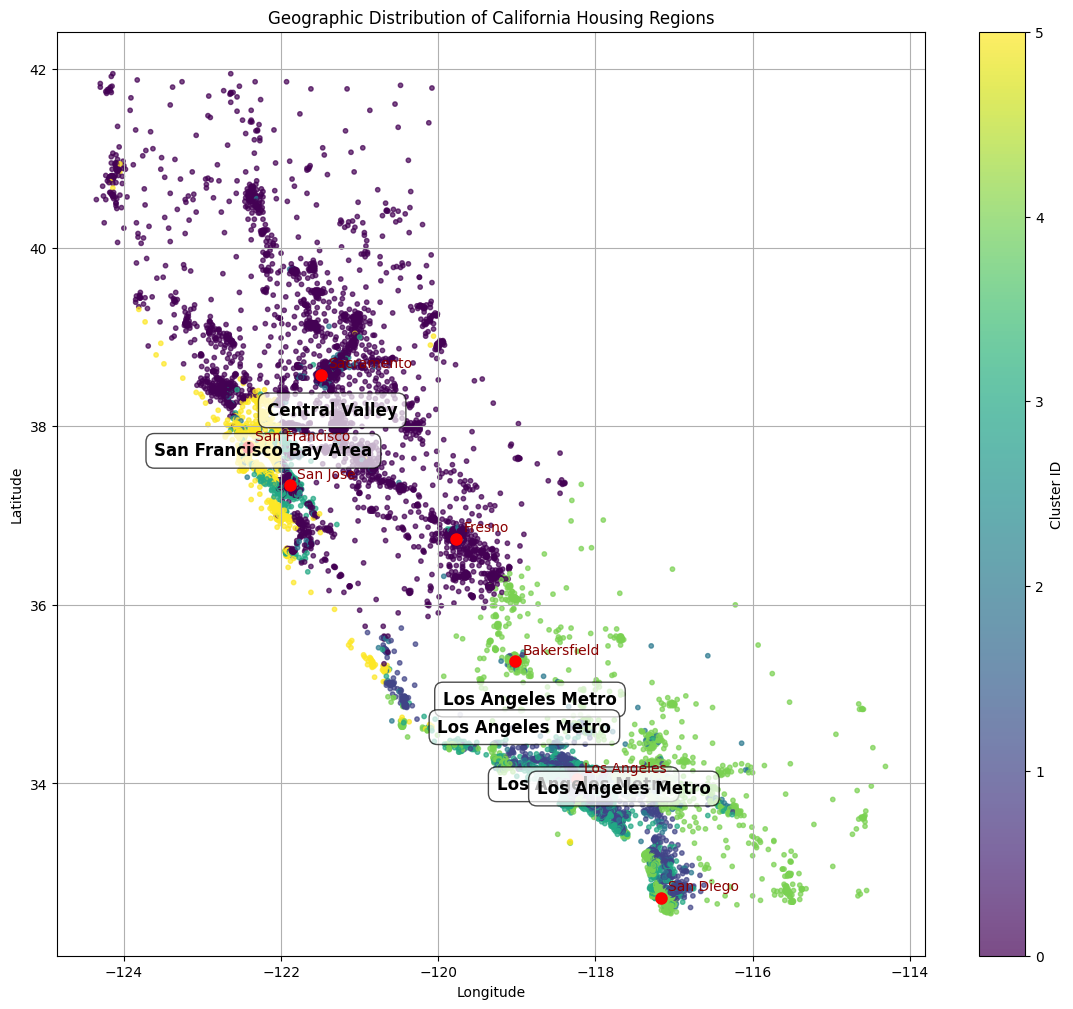

In [217]:
plt.figure(figsize=(14, 12))
scatter = plt.scatter(df['longitude'], df['latitude'], c=df['cluster'],
            cmap='viridis', s=10, alpha=0.7)

for _, region_info in cluster_analysis.iterrows():
    plt.annotate(region_info['region_name'],
                 (region_info['longitude'], region_info['latitude']),
                 fontsize=12, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'),
                 ha='center')

plt.colorbar(scatter, label='Cluster ID')
plt.title('Geographic Distribution of California Housing Regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

major_cities = {
    'San Francisco': (-122.42, 37.77),
    'Los Angeles': (-118.24, 34.05),
    'San Diego': (-117.16, 32.72),
    'Sacramento': (-121.49, 38.58),
    'Fresno': (-119.77, 36.74),
    'San Jose': (-121.89, 37.34),
    'Bakersfield': (-119.02, 35.37)
}

for city, (lon, lat) in major_cities.items():
    plt.plot(lon, lat, 'ro', markersize=8)
    plt.annotate(city, (lon, lat), xytext=(5, 5), textcoords='offset points',
                 fontsize=10, color='darkred')

plt.show()

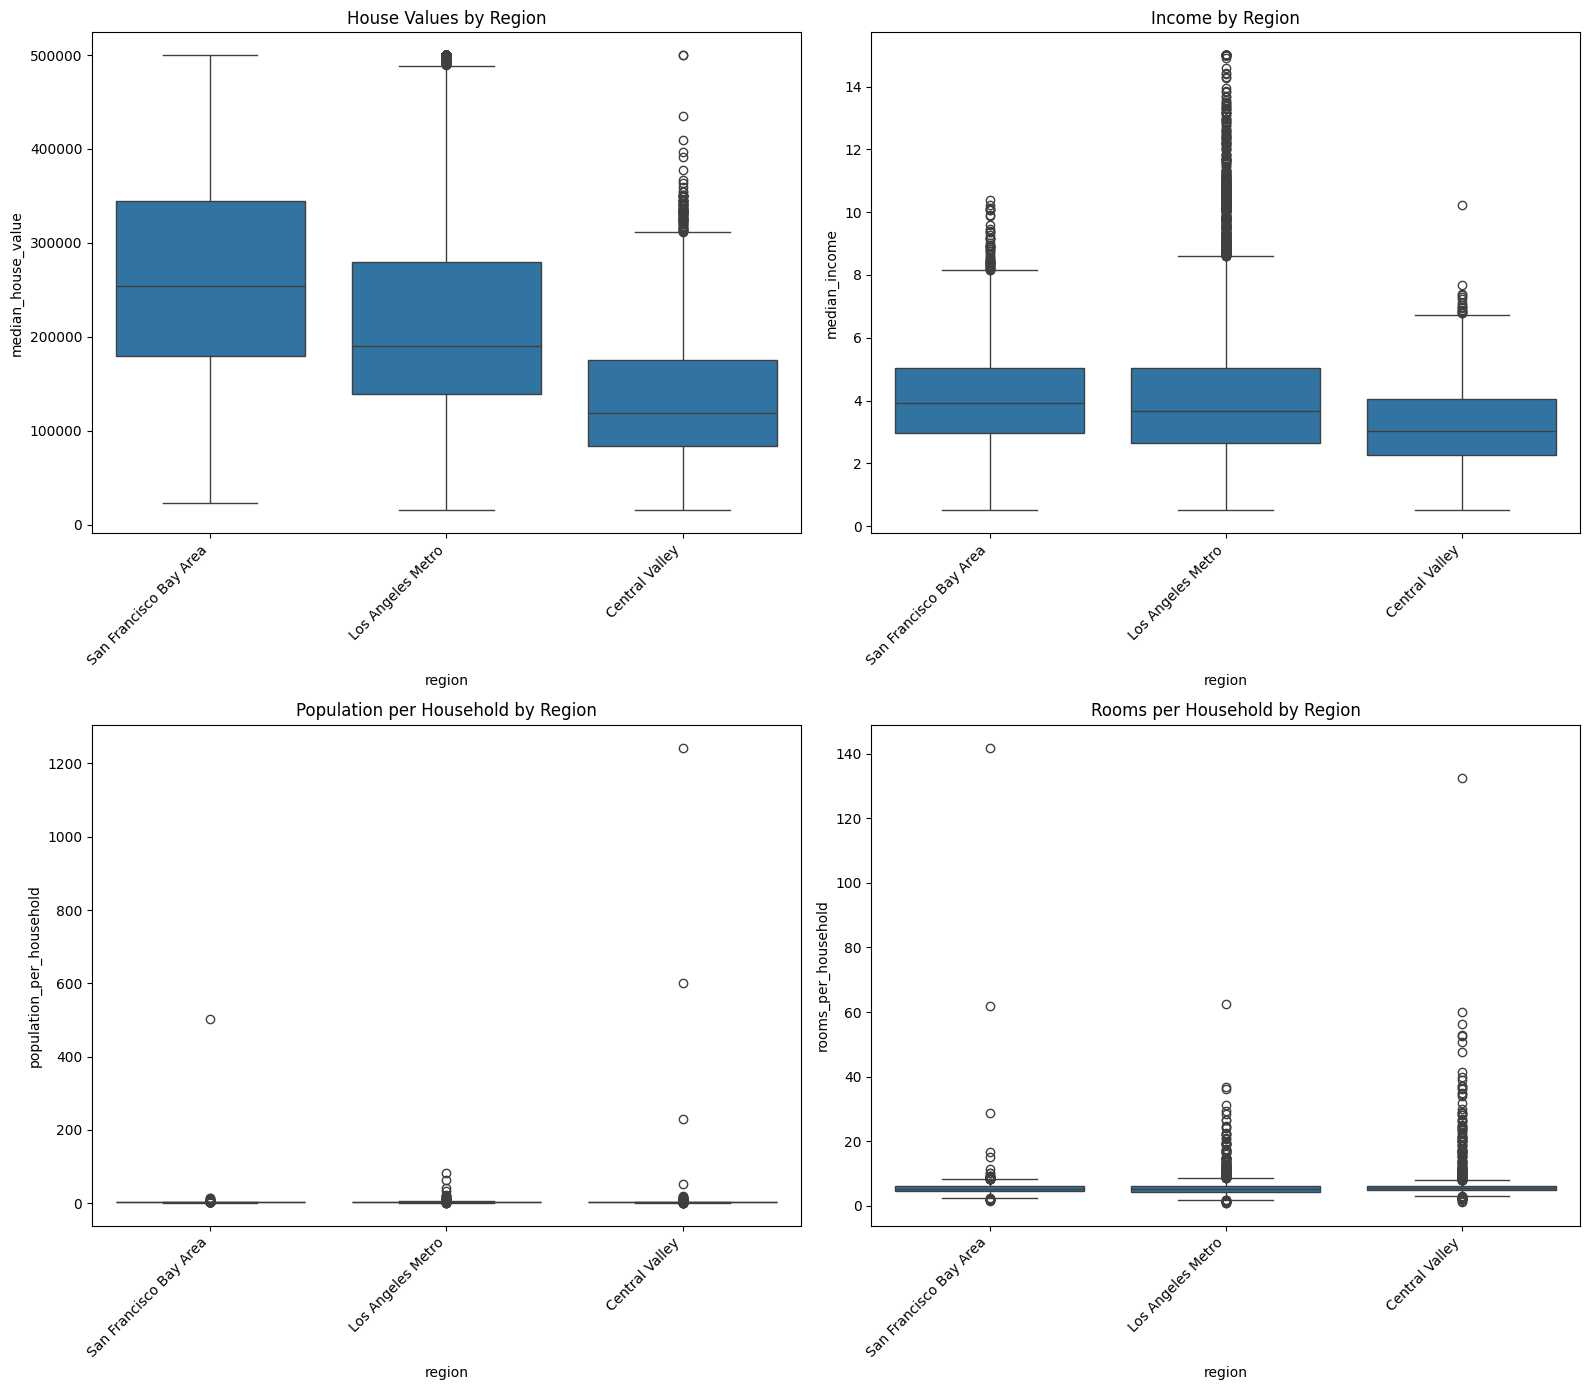

In [218]:
plt.figure(figsize=(16, 14))

plt.subplot(2, 2, 1)
sns.boxplot(x='region', y='median_house_value', data=df)
plt.title('House Values by Region')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 2)
sns.boxplot(x='region', y='median_income', data=df)
plt.title('Income by Region')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 3)
sns.boxplot(x='region', y='population_per_household', data=df)
plt.title('Population per Household by Region')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 4)
sns.boxplot(x='region', y='rooms_per_household', data=df)
plt.title('Rooms per Household by Region')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [219]:
regional_profile = df.groupby('region').agg({
    'median_house_value': 'mean',
    'median_income': 'mean',
    'housing_median_age': 'mean',
    'population': 'sum',
    'households': 'sum',
    'total_rooms': 'sum',
    'ocean_proximity': lambda x: x.mode()[0]
}).sort_values('median_house_value', ascending=False)

regional_profile['avg_rooms_per_household'] = regional_profile['total_rooms'] / regional_profile['households']
regional_profile['population_density'] = regional_profile['population'] / regional_profile['households']

print("\nCalifornia Housing Regional Profiles:")
display(regional_profile.round(2))


California Housing Regional Profiles:


,median_house_value,median_income,housing_median_age,population,households,total_rooms,ocean_proximity,avg_rooms_per_household,population_density
region,,,,,,,,,
San Francisco Bay Area,267563.83,4.10,36.70,3496748.0,1370963.0,7079184.0,NEAR BAY,5.16,2.55
Los Angeles Metro,222384.22,4.09,28.15,19629921.0,6730909.0,35269995.0,<1H OCEAN,5.24,2.92
Central Valley,136177.96,3.22,25.30,6295171.0,2208627.0,12052971.0,INLAND,5.46,2.85


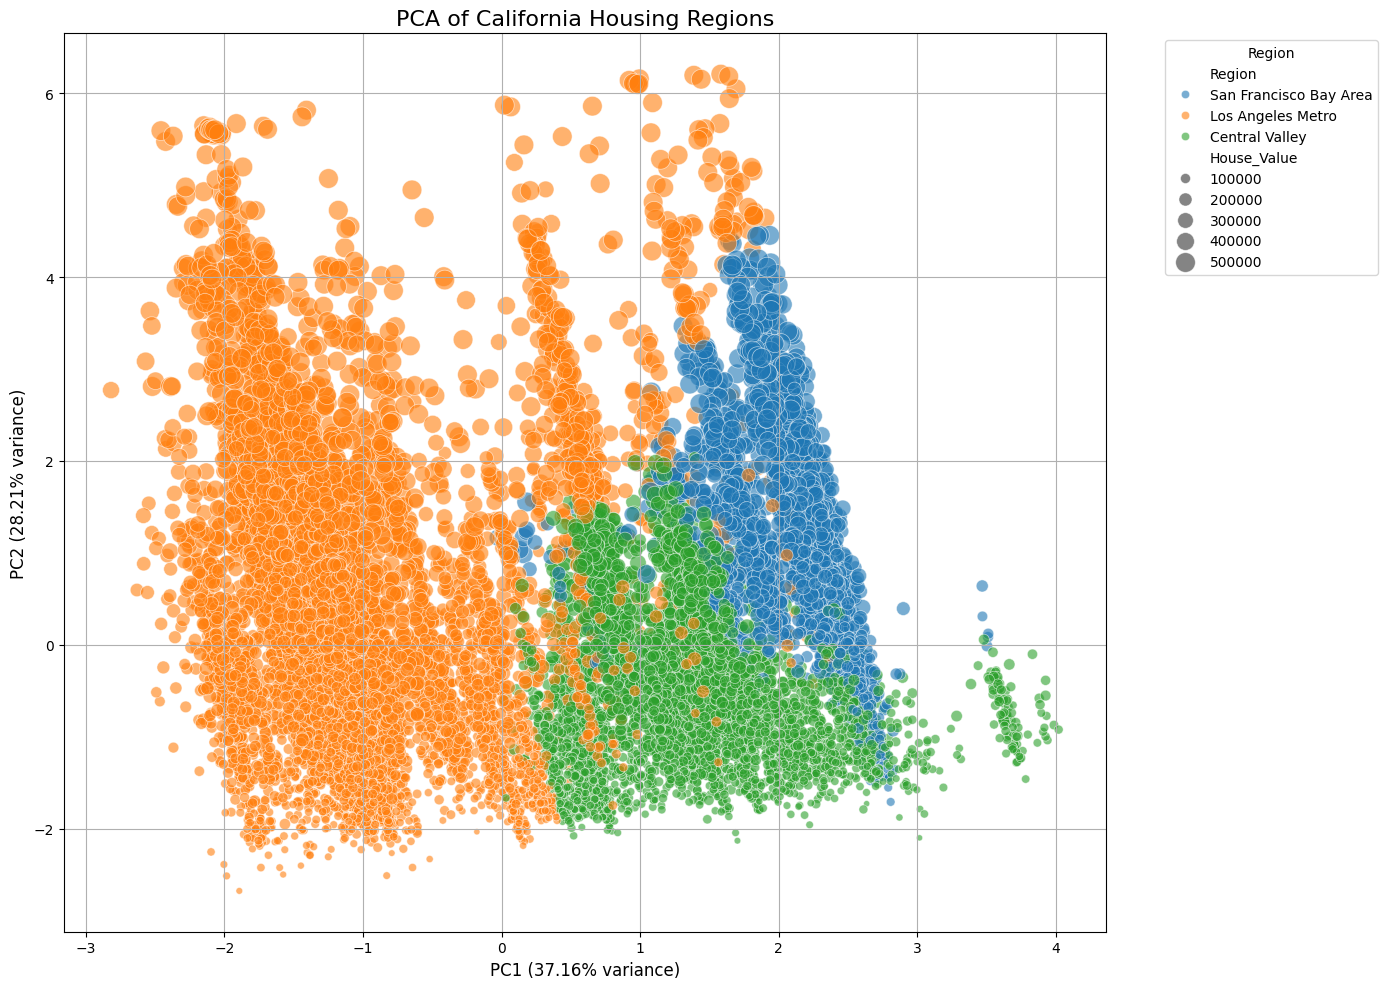

In [221]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Region'] = df['region']
pca_df['House_Value'] = df['median_house_value']

plt.figure(figsize=(14, 10))
sns.scatterplot(x='PC1', y='PC2', hue='Region', palette='tab10',
                size='House_Value', sizes=(20, 200), alpha=0.6, data=pca_df)
plt.title('PCA of California Housing Regions', fontsize=16)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

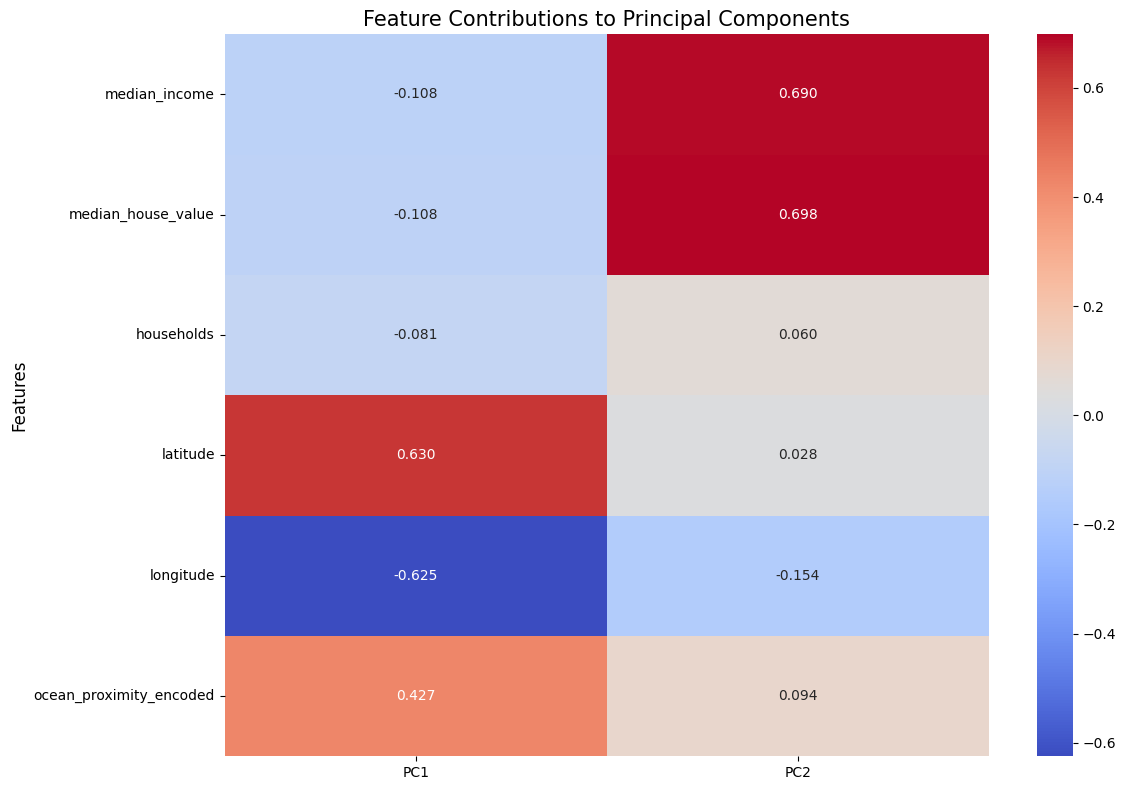

In [222]:
pca_components = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=cluster_features
)

plt.figure(figsize=(12, 8))
sns.heatmap(pca_components, cmap='coolwarm', annot=True, fmt='.3f')
plt.title('Feature Contributions to Principal Components', fontsize=15)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

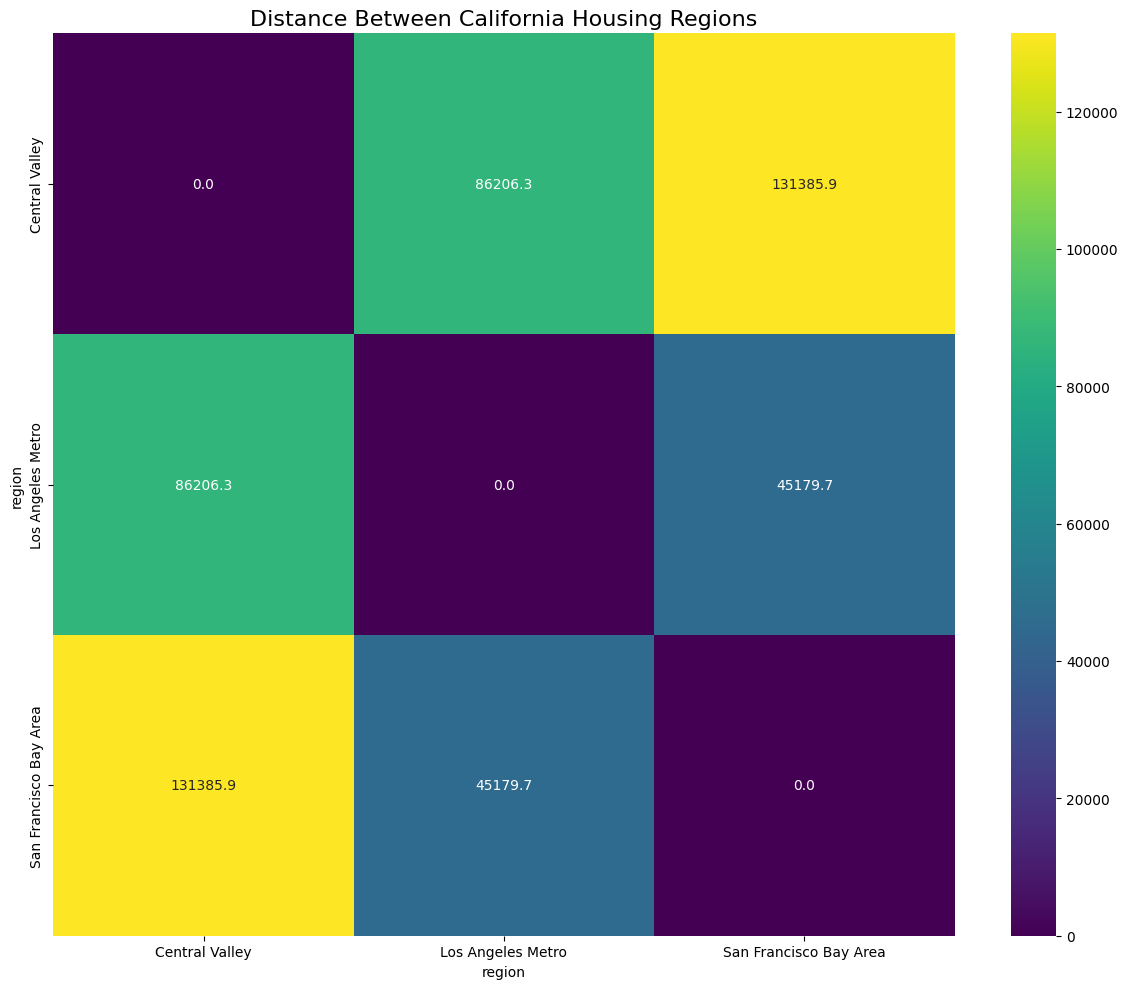

In [223]:
# Calculate and visualize regional distinctiveness
from scipy.spatial.distance import pdist, squareform

region_centroids = df.groupby('region')[cluster_features].mean()

centroid_dist = pdist(region_centroids.values)
dist_matrix = squareform(centroid_dist)
dist_df = pd.DataFrame(dist_matrix, index=region_centroids.index, columns=region_centroids.index)

plt.figure(figsize=(12, 10))
sns.heatmap(dist_df, annot=True, cmap='viridis', fmt='.1f')
plt.title('Distance Between California Housing Regions', fontsize=16)
plt.tight_layout()
plt.show()

In [228]:
# Create interactive map visualization with Plotly using region names
fig = px.scatter_mapbox(df.sample(500),
                        lat="latitude",
                        lon="longitude",
                        color="region",
                        size="median_house_value",
                        color_discrete_sequence=px.colors.qualitative.Bold,
                        size_max=15,
                        zoom=5,
                        hover_data=["median_income", "median_house_value", "households", "ocean_proximity"])

fig.update_layout(mapbox_style="open-street-map",
                  title="California Housing Regions",
                  width=1200,
                  height=800,
                  legend=dict(title="California Region"))

for region, data in df.groupby('region'):
    centroid_lat = data['latitude'].mean()
    centroid_lon = data['longitude'].mean()

    fig.add_trace(go.Scattermapbox(
        lat=[centroid_lat],
        lon=[centroid_lon],
        mode='markers+text',
        marker=dict(size=15, color='black'),
        text=[region],
        textfont=dict(size=15, color='black'),
        textposition="top center",
        name=f"{region} (Centroid)",
        showlegend=False
    ))

fig.show()

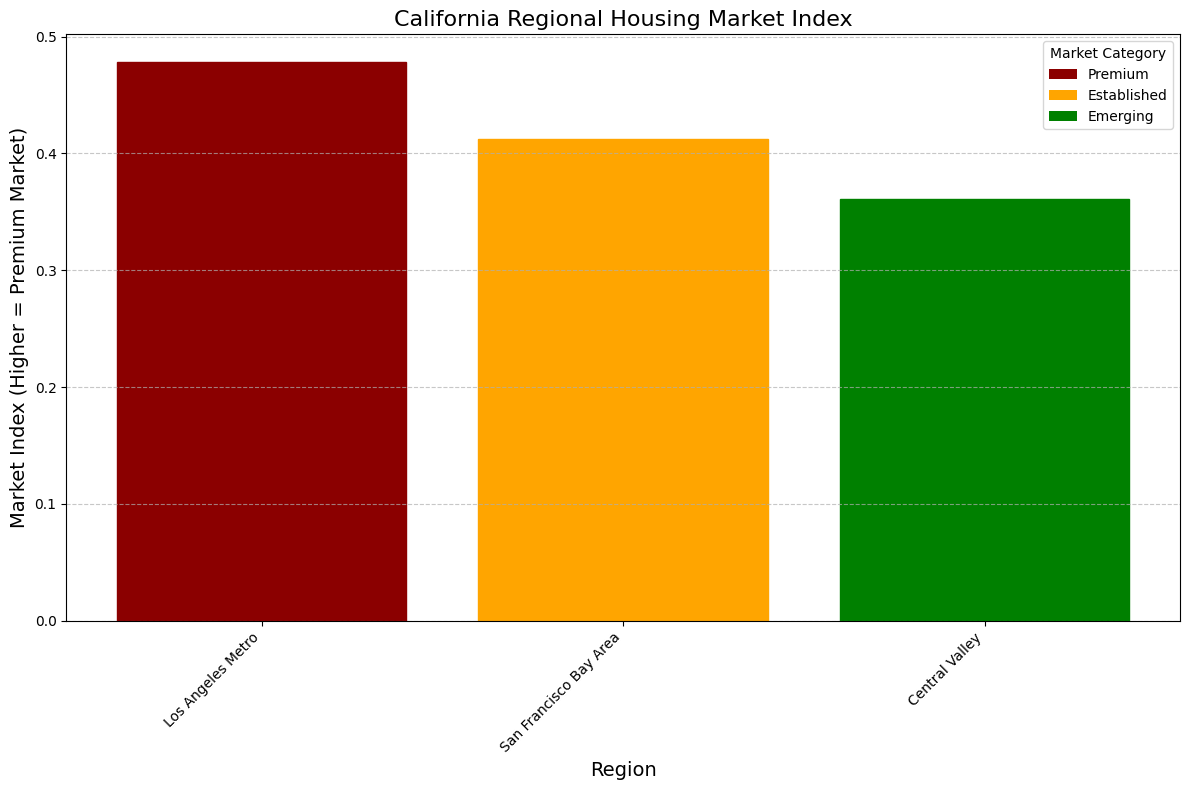

In [229]:
# Regional Housing Market Index
df['market_index'] = (
    (df['median_house_value'] / df['median_house_value'].max()) * 0.5 +
    (df['median_income'] / df['median_income'].max()) * 0.3 +
    (5 - df['ocean_proximity_encoded']) / 4 * 0.2
)

regional_market = df.groupby('region')['market_index'].mean().sort_values(ascending=False).reset_index()
regional_market['market_category'] = pd.qcut(regional_market['market_index'], q=3, labels=['Emerging', 'Established', 'Premium'])

plt.figure(figsize=(12, 8))
bars = plt.bar(regional_market['region'], regional_market['market_index'], color='skyblue')

colors = {'Premium': 'darkred', 'Established': 'orange', 'Emerging': 'green'}
for i, bar in enumerate(bars):
    category = regional_market.iloc[i]['market_category']
    bar.set_color(colors[category])

plt.title('California Regional Housing Market Index', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Market Index (Higher = Premium Market)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=category) for category, color in colors.items()]
plt.legend(handles=legend_elements, title='Market Category')

plt.tight_layout()
plt.show()